In [1]:
import sys
import os
import json
import time
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [36]:
def load_model(path:str):
    
    if not os.path.exists(path):
        raise OSError('Path: {0} does not exist'.format(path))
        
    with open(os.path.join(path, 'settings.json')) as setting_file:
        settings = json.load(setting_file)
        
    # load correct model
    net = None
    if settings['model'] == 'alexnet':
        net = models.alexnet()
        net.classifier[6] = nn.Linear(in_features=4096, out_features=7, bias=True)
    elif settings['model'] == 'vgg11':
        net = models.vgg11_bn()
        net.classifier[6] = nn.Linear(in_features=4096, out_features=7, bias=True)
    elif settings['model'] == 'vgg':
        net = models.vgg19_bn()
        net.classifier[6] = nn.Linear(in_features=4096, out_features=7, bias=True)
    elif settings['model'] == 'resnet':
        net = models.resnet18()
        net.fc = nn.Linear(in_features=512, out_features=7, bias=True)
    elif settings['model'] == 'densenet':
        net = models.densenet121()
        net.classifier = nn.Linear(in_features=1024, out_features=7, bias=True)
        
    net.load_state_dict(torch.load(os.path.join(path, 'final_model')))    
    settings['net'] = net
    
    # load in loss information
    settings['t_loss'] = np.load(os.path.join(path, 'train_loss.npy'))
    settings['v_loss'] = np.load(os.path.join(path, 'valid_loss.npy'))
    
    # load predictions 
    settings['test_preds'] = np.load(os.path.join(path, 'test_predictions.npy'))
    
    return settings

In [120]:
def plt_model(info:dict):
    plt.figure(figsize=(8, 5))
    plt.plot(list(range(1, info['num_epochs']+1)), info['t_loss'], label='Training Loss')
    plt.plot(list(range(1, info['num_epochs']+1)), info['v_loss'], label='Validation Loss')

    plt.title('Loss Over Training Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.xlabel('Epoch Number')

    plt.xticks(np.linspace(0, info['num_epochs'], 11))
    plt.yticks(np.linspace(0, np.around(np.max(info['v_loss']), 2) *1.1, 8))
    plt.grid(True)

    plt.legend()
    plt.show()

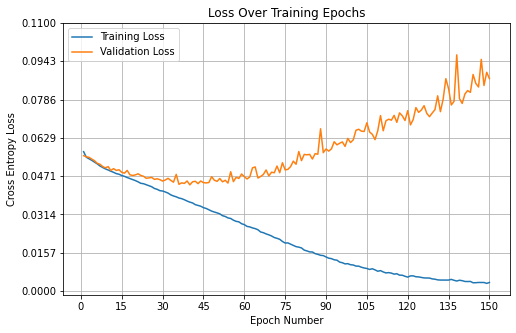

In [244]:
model_path = './models/lr-005.vgg.model//'
model_info = load_model(model_path)
plt_model(model_info)

In [245]:
def run_prediction(info:dict, image:str):
    image = cv2.cvtColor(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB)
    image = transforms.ToTensor()(image)
    image = transforms.Resize(size=(224,224))(image)
    image = torch.unsqueeze(image, 0)
    
    plt.imshow(image[0].permute(1, 2, 0))
        
    return info['net'](image)

[-1.6389699 -6.2987356 -4.53858   10.24136    2.683056  -2.7071693
  2.211332 ]
Happy


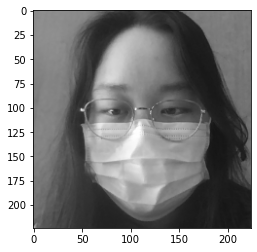

In [247]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
image_path = './assets/r_neutral.png'
scores = run_prediction(model_info, image_path).detach().numpy().squeeze()
print(scores)

emote = np.argmax(scores)

if emote == 0:
    print('Angry')
elif emote == 1:
    print('Disgust')
elif emote == 2:
    print('Fear')
elif emote == 3:
    print('Happy')
elif emote == 4:
    print('Sad')
elif emote == 5:
    print('Surprise')
elif emote == 6:
    print('Neutral')